In [1]:
import cufflinks as cf
import numpy as np
import optuna
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf
from functools import reduce
from plotly.subplots import make_subplots
from scipy.signal import argrelextrema
from strategies_indicators import *
cf.set_config_file(offline=True)

# Forex Data

In [2]:
# load eur/usd
eurusd = pd.read_csv("Course_Materials/eurusd.csv", parse_dates=["Date"], index_col="Date")
eurusd["daily_relative_return"] = (eurusd/eurusd.shift(1))
eurusd["daily_log_return"] = np.log(eurusd["daily_relative_return"])
eurusd["cumulative_return"] = np.exp(np.cumsum(eurusd["daily_log_return"]))
eurusd["cumulative_max"] = eurusd["cumulative_return"].cummax()
eurusd["drawdown"] = eurusd["cumulative_max"] - eurusd["cumulative_return"]
eurusd.dropna(inplace=True)
print(eurusd.shape)
eurusd.head()

(4274, 6)


,price,daily_relative_return,daily_log_return,cumulative_return,cumulative_max,drawdown
Date,,,,,,
2004-01-02,1.258194,1.000000,0.000000,1.000000,1.000000,0.000000
2004-01-05,1.268698,1.008348,0.008313,1.008348,1.008348,0.000000
2004-01-06,1.272103,1.002684,0.002681,1.011055,1.011055,0.000000
2004-01-07,1.264095,0.993705,-0.006315,1.004690,1.011055,0.006365
2004-01-08,1.277498,1.010603,0.010547,1.015343,1.015343,0.000000


In [3]:
print(eurusd.iloc[0])
print(eurusd.iloc[-1])

price                    1.258194
daily_relative_return    1.000000
daily_log_return         0.000000
cumulative_return        1.000000
cumulative_max           1.000000
drawdown                 0.000000
Name: 2004-01-02 00:00:00, dtype: float64
price                    1.124720
daily_relative_return    1.001901
daily_log_return         0.001899
cumulative_return        0.893916
cumulative_max           1.270709
drawdown                 0.376792
Name: 2020-06-30 00:00:00, dtype: float64


In [4]:
# invest 1 $ => return at the end
# default strategy => buy and hold
print(reduce(lambda x, y: x*y, eurusd["daily_relative_return"]))
print(np.exp(np.sum(eurusd["daily_log_return"])))
print(eurusd["cumulative_return"][-1])
print(eurusd["price"][-1] / eurusd["price"][0])

0.8939163935445146
0.8939163935445148
0.8939163935445149
0.8939163935445141


<AxesSubplot:xlabel='Date'>

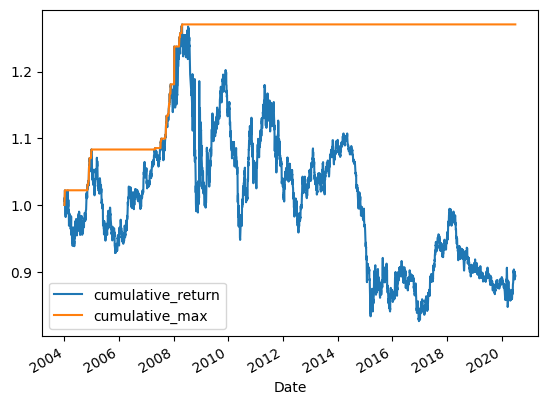

In [5]:
eurusd[["cumulative_return", "cumulative_max"]].plot()

In [6]:
eurusd["drawdown"].idxmax(), eurusd["drawdown"].max()

(Timestamp('2016-12-21 00:00:00'), 0.4448840569933439)

In [7]:
# NOTE: Implications 
# => to calculate relative returns on a period you can calculate multiplication of the relative returns for each day
# => but if you calculate log of this, you can sum the log values for a period => log(a x b x c) = log(a) + log(b) + log(c)

# Load Data

In [8]:
# ingest data
nasdaq_bio = yf.download(tickers=['vtyx', 'tnya'], period='2y', interval='60m')
nasdaq_bio.dropna(subset=[("Close", "VTYX")], inplace=True)
print(nasdaq_bio.shape)
nasdaq_bio.tail(10)

[*********************100%***********************]  2 of 2 completed
(3296, 12)


Adj Close            Close               High             \
                         TNYA       VTYX  TNYA       VTYX    TNYA       VTYX   
Datetime                                                                       
2023-09-07 13:30:00      3.30  32.650002  3.30  32.650002  3.3000  32.990002   
2023-09-07 14:30:00      3.31  32.990002  3.31  32.990002  3.3200  33.160000   
2023-09-07 15:30:00      3.30  33.419998  3.30  33.419998  3.3200  33.459999   
2023-09-08 09:30:00      3.20  33.139999  3.20  33.139999  3.3100  33.500000   
2023-09-08 10:30:00      3.15  33.049999  3.15  33.049999  3.2100  33.205002   
2023-09-08 11:30:00      3.12  33.610001  3.12  33.610001  3.1754  33.639999   
2023-09-08 12:30:00      3.13  33.810001  3.13  33.810001  3.1400  33.950001   
2023-09-08 13:30:00      3.09  33.775002  3.09  33.775002  3.1400  33.990002   
2023-09-08 14:30:00      2.98  34.189999  2.98  34.189999  3.1100  34.189999   
2023-09-08 15:30:00      3.10  34.209999  3.10  34.209999  3.1100  34.529999   

                      Low               Open              Volume            
                     TNYA       VTYX    TNYA       VTYX     TNYA      VTYX  
Datetime                                                                    
2023-09-07 13:30:00  3.23  32.430000  3.2300  32.430000  17409.0   43996.0  
2023-09-07 14:30:00  3.28  32.650002  3.3000  32.650002  12022.0   41529.0  
2023-09-07 15:30:00  3.27  32.970001  3.3100  33.099998  33764.0  109647.0  
2023-09-08 09:30:00  3.11  32.595001  3.3100  33.349998  26530.0   32878.0  
2023-09-08 10:30:00  3.15  32.500000  3.2100  33.080002  17193.0   52551.0  
2023-09-08 11:30:00  3.12  32.980000  3.1501  32.990002  14258.0   58185.0  
2023-09-08 12:30:00  3.09  33.500000  3.1100  33.509998  13968.0   51692.0  
2023-09-08 13:30:00  3.08  33.580002  3.1300  33.875000  26089.0  120222.0  
2023-09-08 14:30:00  2.98  33.619999  3.0900  33.775002  47093.0   89139.0  
2023-09-08 15:30:00  2.97  34.025002  2.9700  34.150002  71783.0  169596.0

In [9]:
# check number of entries
(nasdaq_bio.index.max() - nasdaq_bio.index.min()).days * 252/365 * 7

3320.186301369863

In [10]:
nasdaq_bio["Close"].head()
nasdaq_bio["Close"]["TNYA"].head()

Datetime
2021-10-21 09:30:00    21.000000
2021-10-21 11:30:00    20.889999
2021-10-21 12:30:00    20.870001
2021-10-21 13:30:00    20.770000
2021-10-21 14:30:00    20.754999
Name: TNYA, dtype: float64

In [11]:
# iplot
nasdaq_bio.loc["2023":, "Close"].iplot(fill=True, xTitle="Date", yTitle="Price", title="Bioscience Stock Prices")

In [12]:
# individual stock datasets
tnya = nasdaq_bio.swaplevel(axis=1).TNYA.copy()
vtyx = nasdaq_bio.swaplevel(axis=1).VTYX.copy()
vtyx.head(1)

,Adj Close,Close,High,Low,Open,Volume
Datetime,,,,,,
2021-10-21 09:30:00,16.0,16.0,16.0,16.0,16.0,0.0


In [13]:
# plot candle of a day for VTYX
vtyx.loc["2023-07-17", :].iplot(kind="candle")

# Indicators & Strategies

+ SMA: simple moving average
+ EMA: exponential moving average
+ SMA & EMA: together
+ MACD: moving average convergence & divergence
+ RSI: relative strength index
+ SO: stochastic oscillator
+ SOA: stochastic oscillator alternative
+ BB: bollinger bands
+ PP: pivot point
+ FR: fibonacci retracement
+ ROC: rate of change
+ WR: williams %r
+ CMF: chaikin money flow
+ OBV: on balance volume
+ ATR: average true range

In [ ]:
vtyx_copy = vtyx.copy()

In [ ]:
# SMA: simple moving averages
window_sizes = [3, 7, 35, 140, 420]
for window_size in window_sizes:
    vtyx_copy[f'SMA_Close_{window_size}'] = vtyx_copy["Close"].rolling(window=window_size).mean()

# drop nans
vtyx_copy.dropna(inplace=True)

In [ ]:
# plot SMA for VTYX
vtyx_copy[["Close", "SMA_Close_35", "SMA_Close_420"]].iplot()

In [ ]:
# NOTE: Implications 
# => if short moving average crosses above the long moving average => buy (long position!)
# => if short moving average crosses below the long moving average => sell (short position!)

## Simple Moving Average

In [ ]:
# optimize the sma strategy
def objective(trial):
    short_sma = trial.suggest_int('short_sma', 35, 210)
    long_sma = trial.suggest_int('long_sma', 420, 1680)
    try:
        return_value = backtest_strategy(*sma_strategy(vtyx, short_sma, long_sma))
    except:
        return 1
    return return_value

study_sma = optuna.create_study(direction='maximize')
study_sma.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_sma.trials))
print('Best trial:', study_sma.best_trial.params)

In [ ]:
# optimized sma strategy
df_sma, dates_of_buy, dates_of_sell = sma_strategy(vtyx, 132, 1247)
backtest_strategy(df_sma, dates_of_buy, dates_of_sell)

In [ ]:
df_sma

In [ ]:
# plot sma strategy
plot_strategy(df_sma, dates_of_buy, dates_of_sell)

## Exponential Moving Average

In [ ]:
# optimize the ema strategy
def objective(trial):
    short_ema = trial.suggest_int('short_ema', 35, 210)
    long_ema = trial.suggest_int('long_ema', 420, 1680)
    try:
        return_value = backtest_strategy(*ema_strategy(vtyx, short_ema, long_ema))
    except:
        return 1
    return return_value

study_ema = optuna.create_study(direction='maximize')
study_ema.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_ema.trials))
print('Best trial:', study_ema.best_trial.params)

In [ ]:
# optimized ema strategy
df_ema, dates_of_buy, dates_of_sell = ema_strategy(vtyx, 133, 1145)
backtest_strategy(df_ema, dates_of_buy, dates_of_sell)

In [ ]:
# plot ema strategy
plot_strategy(df_ema, dates_of_buy, dates_of_sell)

## SMA / EMA: Combination

In [ ]:
# optimize the sma ema strategy
def objective(trial):
    smaema = trial.suggest_int('smaema', 35, 840)
    try:
        return_value = backtest_strategy(*smaema_strategy(vtyx, smaema))
    except:
        return 1
    return return_value

study_smaema = optuna.create_study(direction='maximize')
study_smaema.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_smaema.trials))
print('Best trial:', study_smaema.best_trial.params)

In [ ]:
# optimized sma ema strategy
df_smaema, dates_of_buy, dates_of_sell = smaema_strategy(vtyx, 49)
backtest_strategy(df_smaema, dates_of_buy, dates_of_sell)

In [ ]:
# plot sma ema strategy
plot_strategy(df_smaema, dates_of_buy, dates_of_sell)

## Moving Average Convergence Divergence

In [ ]:
# optimize the macd strategy
def objective(trial):
    s = trial.suggest_int('s', 42, 126)
    l = trial.suggest_int('l', 140, 224)
    t = trial.suggest_int('t', 35, 105)
    try:
        return_value = backtest_strategy(*macd_strategy(vtyx, s, l, t))
    except:
        return 1
    return return_value

study_macd = optuna.create_study(direction='maximize')
study_macd.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_macd.trials))
print('Best trial:', study_macd.best_trial.params)

In [ ]:
# optimized macd strategy
df_macd, dates_of_buy, dates_of_sell = macd_strategy(vtyx, 122, 204, 61)
backtest_strategy(df_macd, dates_of_buy, dates_of_sell)

In [ ]:
# plot macd strategy
plot_strategy(df_macd, dates_of_buy, dates_of_sell)

## Relative Strength Index

In [ ]:
# optimize the rsi strategy
def objective(trial):
    period = trial.suggest_int('period', 35, 420)
    threshold = trial.suggest_int('threshold', 25, 35)
    try:
        return_value = backtest_strategy(*rsi_strategy(vtyx, period, threshold))
    except:
        return 1
    return return_value

study_rsi = optuna.create_study(direction='maximize')
study_rsi.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_rsi.trials))
print('Best trial:', study_rsi.best_trial.params)

In [ ]:
# optimized rsi strategy
df_rsi, dates_of_buy, dates_of_sell = rsi_strategy(vtyx, 86, 35)
backtest_strategy(df_rsi, dates_of_buy, dates_of_sell)

In [ ]:
# plot rsi strategy
plot_with_threshold(df_rsi, "RSI", dates_of_buy, dates_of_sell, 35)

## Stochastic Oscillator

In [ ]:
# optimize the stochastic oscillator strategy
def objective(trial):
    roll = trial.suggest_int('roll', 35, 210)
    slow = trial.suggest_int('slow', 7, 35)
    try:
        return_value = backtest_strategy(*stochastic_oscillator(vtyx, roll, slow))
    except:
        return 1
    return return_value

study_so = optuna.create_study(direction='maximize')
study_so.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_so.trials))
print('Best trial:', study_so.best_trial.params)

In [ ]:
# optimized so strategy
df_so, dates_of_buy, dates_of_sell = stochastic_oscillator(vtyx, 105, 35)
backtest_strategy(df_so, dates_of_buy, dates_of_sell)

In [ ]:
# plot so strategy
plot_strategy(df_so, dates_of_buy, dates_of_sell)

## Stochastic Oscillator Alternative

In [ ]:
# optimize the stochastic oscillator alternative strategy
def objective(trial):
    roll = trial.suggest_int('roll', 35, 210)
    threshold = trial.suggest_int('threshold', 10, 40)
    try:
        return_value = backtest_strategy(*stochastic_oscillator_alternative(vtyx, roll, threshold))
    except:
        return 1
    return return_value

study_soa = optuna.create_study(direction='maximize')
study_soa.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_soa.trials))
print('Best trial:', study_soa.best_trial.params)

In [ ]:
# optimized soa strategy
df_soa, dates_of_buy, dates_of_sell = stochastic_oscillator_alternative(vtyx, 62, 14)
backtest_strategy(df_soa, dates_of_buy, dates_of_sell)

In [ ]:
# plot soa strategy
plot_with_threshold(df_soa, "K", dates_of_buy, dates_of_sell, 13)

## Bollinger Bands

In [ ]:
# optimize the bb strategy
def objective(trial):
    sma = trial.suggest_int('sma', 35, 210)
    dev = trial.suggest_float('dev', 1, 3)
    try:
        return_value = backtest_strategy(*bollinger_bands(vtyx, sma, dev))
    except:
        return 1
    return return_value

study_bb = optuna.create_study(direction='maximize')
study_bb.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_bb.trials))
print('Best trial:', study_bb.best_trial.params)

In [ ]:
# optimized bb strategy
df_bb, dates_of_buy, dates_of_sell = bollinger_bands(vtyx, 50, 2.1)
backtest_strategy(df_bb, dates_of_buy, dates_of_sell)

In [ ]:
# plot bb strategy
plot_bollinger_bands(df_bb, dates_of_buy, dates_of_sell)

## Pivot Point

In [ ]:
# pivot point strategy
df_pp, dates_of_buy, dates_of_sell = pivot_point(vtyx, "R1")
backtest_strategy(df_pp, dates_of_buy, dates_of_sell)

In [ ]:
# pivot point strategy
df_pp, dates_of_buy, dates_of_sell = pivot_point(vtyx, "R2")
backtest_strategy(df_pp, dates_of_buy, dates_of_sell)

In [ ]:
len(dates_of_buy), len(dates_of_sell)

In [ ]:
dates_of_buy[:5]

In [ ]:
dates_of_sell[:5]

In [ ]:
print(vtyx.shape, df_pp.shape)
date_difference(vtyx, df_pp)

In [ ]:
check_day_data(df_pp, '2021-11-25')

In [ ]:
plot_pivot_point(df_pp, dates_of_buy, dates_of_sell)

## Fibonacci Retracement

In [ ]:
# fibonacci retracement strategy
df_fr, dates_of_buy, dates_of_sell = fibonacci_retracement(vtyx, 420)
backtest_strategy(df_fr, dates_of_buy, dates_of_sell)

In [ ]:
len(dates_of_buy), len(dates_of_sell)

In [ ]:
df_fr.trend.value_counts()

In [ ]:
# plot strategy
plot_fibonacci_retracement(df_fr, dates_of_buy, dates_of_sell)

## Rate of Change

In [ ]:
# optimize the roc strategy
def objective(trial):
    n = trial.suggest_int('n', 14, 1260)
    try:
        return_value = backtest_strategy(*rate_of_change(vtyx, n))
    except:
        return 1
    return return_value

study_roc = optuna.create_study(direction='maximize')
study_roc.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_roc.trials))
print('Best trial:', study_roc.best_trial.params)

In [ ]:
# rate of change strategy
df_roc, dates_of_buy, dates_of_sell = rate_of_change(vtyx, 375)
backtest_strategy(df_roc, dates_of_buy, dates_of_sell)

In [ ]:
# plot strategy
plot_rate_of_change(df_roc, dates_of_buy, dates_of_sell)

## Williams %R

In [ ]:
# optimize the wr strategy
def objective(trial):
    n = trial.suggest_int('n', 14, 1260)
    try:
        return_value = backtest_strategy(*williams_r(vtyx, n))
    except:
        return 1
    return return_value

study_wr = optuna.create_study(direction='maximize')
study_wr.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_wr.trials))
print('Best trial:', study_wr.best_trial.params)

In [ ]:
# fibonacci retracement strategy
df_wr, dates_of_buy, dates_of_sell = williams_r(vtyx, 467)
backtest_strategy(df_wr, dates_of_buy, dates_of_sell)

In [ ]:
# plot strategy
plot_williams_r(df_wr, dates_of_buy, dates_of_sell)

## Chaikin Money Flow

In [ ]:
# optimize the wr strategy
def objective(trial):
    n = trial.suggest_int('n', 14, 1260)
    signal = trial.suggest_int('signal', 0, 50)
    try:
        return_value = backtest_strategy(*chaikin_money_flow(vtyx, n, signal))
    except:
        return 1
    return return_value

study_cmf = optuna.create_study(direction='maximize')
study_cmf.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study_cmf.trials))
print('Best trial:', study_cmf.best_trial.params)

In [ ]:
# chaikin money flow strategy
df_cmf, dates_of_buy, dates_of_sell = chaikin_money_flow(vtyx, 546, 0)
backtest_strategy(df_cmf, dates_of_buy, dates_of_sell)

In [ ]:
# plot strategy
plot_chaikin_money_flow(df_cmf, dates_of_buy, dates_of_sell, 0)

## On-Balance Volume

In [ ]:
df_obv = on_balance_volume(vtyx)
df_obv.head()

## Average True Range

In [ ]:
df_atr = average_true_range(vtyx, 70)
df_atr.head()

# Set Training Data

In [ ]:
# load nasdaq screener data
nasdaq_list = pd.read_csv("data/nasdaq_screener_1693340401219.csv")
print(nasdaq_list.shape)
nasdaq_list.head(1)

In [ ]:
# find similar industries
bio_sectors = [i for i in list(nasdaq_list.Industry.unique()) if ("bio" in str(i).lower()) | ("medic" in str(i).lower())]
bio_sectors

In [ ]:
# find company symbols in these sectors
company_list = nasdaq_list[nasdaq_list.Industry.isin(bio_sectors)].Symbol
len(company_list), company_list

In [ ]:
# ingest data
df_bio = yf.download(tickers=list(company_list), period='2y', interval='60m') # tickers = ['vtyx', 'tnya']
df_bio = df_bio.dropna(axis=1, thresh=2500)
df_bio = df_bio.swaplevel(axis=1)
print(df_bio.shape)
df_bio.head()

In [ ]:
df_bio.VTYX.tail()

In [ ]:
# save data
df_bio.to_csv("data/df_bio_nasdaq.csv", index=True)

# Optimize Indicators

In [14]:
# load data
df_bio = pd.read_csv("data/df_bio_nasdaq.csv", header=[0, 1], index_col=0)
print(df_bio.shape)
df_bio.head(1)

(3512, 5928)


,A,AADI,ABBV,ABCL,ABCM,ABEO,ABIO,ABOS,ABSI,ABT,...,YMAB,ZIMV,ZIVO,ZLAB,ZNTL,ZOM,ZTS,ZYME,ZYNE,ZYXI
,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,...,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-02 09:30:00,177.570007,28.142599,112.57,16.950001,21.26,32.75,3.0321,17.120001,19.245001,128.509995,...,13917.0,NaN,11984.0,0.0,30025.0,7638035.0,219359.0,7950.0,173882.0,14233.0


In [15]:
# fill missing values
df_bio.fillna(method='ffill', inplace=True)
df_bio.fillna(method='bfill', inplace=True)

In [16]:
# find companies
companies = list(df_bio.columns.get_level_values(0).unique())
len(companies)

988

In [17]:
# mean change in price: start to end
changes = [df_bio[company].iloc[-1].Close / df_bio[company].iloc[0].Close for company in companies]
np.mean(changes)

0.4640260360646511

In [18]:
# filter companies
surviving_companies = [company for company in companies if df_bio[company].iloc[-1].Close / df_bio[company].iloc[0].Close > 0.15]
print(len(surviving_companies))
df_bio = df_bio[surviving_companies]
df_bio.shape

665


(3512, 3990)

In [19]:
# mean change in price: start to end
changes = [df_bio[company].iloc[-1].Close / df_bio[company].iloc[0].Close for company in surviving_companies]
np.mean(changes)

0.6566025011135981

## Simple Moving Average

In [ ]:
# optimize the sma strategy on all companies
def sma_for_all(short_sma, long_sma):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # sma strategy
        df_company, dates_of_buy, dates_of_sell = sma_strategy(df_company, short_sma, long_sma)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

def objective(trial):
    short_sma = trial.suggest_int('short_sma', 35, 210)
    long_sma = trial.suggest_int('long_sma', 420, 1680)
    try:
        return_value = sma_for_all(short_sma, long_sma)
    except:
        return 1
    return return_value

study_sma = optuna.create_study(direction='maximize')
study_sma.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study_sma.trials))
print('Best trial:', study_sma.best_trial.params)

In [ ]:
df_company, dates_of_buy, dates_of_sell = sma_strategy(df_bio.VTYX, 200, 1200)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## Exponential Moving Average

In [ ]:
# optimize the ema strategy on all companies
def ema_for_all(short_ema, long_ema):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # ema strategy
        df_company, dates_of_buy, dates_of_sell = ema_strategy(df_company, short_ema, long_ema)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the ema strategy
def objective(trial):
    short_ema = trial.suggest_int('short_ema', 35, 210)
    long_ema = trial.suggest_int('long_ema', 420, 1680)
    try:
        return_value = ema_for_all(short_ema, long_ema)
    except:
        return 1
    return return_value

study_ema = optuna.create_study(direction='maximize')
study_ema.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study_ema.trials))
print('Best trial:', study_ema.best_trial.params)

In [ ]:
df_company, dates_of_buy, dates_of_sell = ema_strategy(df_bio.VTYX, 150, 1350)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## SMA / EMA: Combination

In [ ]:
# optimize the smaema strategy on all companies
def smaema_for_all(smaema):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # smaema strategy
        df_company, dates_of_buy, dates_of_sell = smaema_strategy(df_company, smaema)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the sma ema strategy
def objective(trial):
    smaema = trial.suggest_int('smaema', 35, 840)
    try:
        return_value = smaema_for_all(smaema)
    except:
        return 1
    return return_value

study_smaema = optuna.create_study(direction='maximize')
study_smaema.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study_smaema.trials))
print('Best trial:', study_smaema.best_trial.params)

In [ ]:
df_company, dates_of_buy, dates_of_sell = smaema_strategy(df_bio.VTYX, 275)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## Moving Average Convergence Divergence

In [ ]:
# optimize the macd strategy on all companies
def macd_for_all(s, l, t):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # macd strategy
        df_company, dates_of_buy, dates_of_sell = macd_strategy(df_company, s, l, t)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the macd strategy
def objective(trial):
    s = trial.suggest_int('s', 42, 126)
    l = trial.suggest_int('l', 140, 224)
    t = trial.suggest_int('t', 35, 105)
    try:
        return_value = macd_for_all(s, l, t)
    except:
        return 1
    return return_value

study_macd = optuna.create_study(direction='maximize')
study_macd.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study_macd.trials))
print('Best trial:', study_macd.best_trial.params)

In [ ]:
df_company, dates_of_buy, dates_of_sell = macd_strategy(df_bio.VTYX, 125, 170, 100)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## Relative Strength Index

In [ ]:
# optimize the rsi strategy on all companies
def rsi_for_all(period, threshold):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # rsi strategy
        df_company, dates_of_buy, dates_of_sell = rsi_strategy(df_company, period, threshold)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the rsi strategy
def objective(trial):
    period = trial.suggest_int('period', 35, 420)
    threshold = trial.suggest_int('threshold', 25, 35)
    try:
        return_value = rsi_for_all(period, threshold)
    except:
        return 1
    return return_value
    
study_rsi = optuna.create_study(direction='maximize')
study_rsi.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study_rsi.trials))
print('Best trial:', study_rsi.best_trial.params)

In [ ]:
df_company, dates_of_buy, dates_of_sell = rsi_strategy(df_bio.VTYX, 105, 35)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## Stochastic Oscillator

In [ ]:
# optimize the stochastic oscillator strategy on all companies
def stochastic_oscillator_for_all(roll, slow):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # stochastic oscillator strategy
        df_company, dates_of_buy, dates_of_sell = stochastic_oscillator(df_company, roll, slow)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the stochastic oscillator strategy
def objective(trial):
    roll = trial.suggest_int('roll', 35, 210)
    slow = trial.suggest_int('slow', 7, 35)
    try:
        return_value = stochastic_oscillator_for_all(roll, slow)
    except:
        return 1
    return return_value

study_so = optuna.create_study(direction='maximize')
study_so.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study_so.trials))
print('Best trial:', study_so.best_trial.params)

In [ ]:
df_company, dates_of_buy, dates_of_sell = stochastic_oscillator(df_bio.VTYX, 200, 15)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## Stochastic Oscillator Alternative

In [ ]:
# optimize the stochastic oscillator alternative strategy on all companies
def stochastic_oscillator_alternative_for_all(roll, threshold):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # stochastic oscillator alternative strategy
        df_company, dates_of_buy, dates_of_sell = stochastic_oscillator_alternative(df_company, roll, threshold)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the stochastic oscillator alternative strategy
def objective(trial):
    roll = trial.suggest_int('roll', 35, 210)
    threshold = trial.suggest_int('threshold', 10, 40)
    try:
        return_value = stochastic_oscillator_alternative_for_all(roll, threshold)
    except:
        return 1
    return return_value

study_soa = optuna.create_study(direction='maximize')
study_soa.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study_soa.trials))
print('Best trial:', study_soa.best_trial.params)

In [ ]:
df_company, dates_of_buy, dates_of_sell = stochastic_oscillator_alternative(df_bio.VTYX, 35, 40)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## Bollinger Bands

In [ ]:
# optimize the bb strategy on all companies
def bb_for_all(sma, dev):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # bb strategy
        df_company, dates_of_buy, dates_of_sell = bollinger_bands(df_company, sma, dev)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the bb strategy
def objective(trial):
    sma = trial.suggest_int('sma', 35, 210)
    dev = trial.suggest_float('dev', 1, 3)
    try:
        return_value = bb_for_all(sma, dev)
    except:
        return 1
    return return_value

study_bb = optuna.create_study(direction='maximize')
study_bb.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study_bb.trials))
print('Best trial:', study_bb.best_trial.params)

In [ ]:
df_company, dates_of_buy, dates_of_sell = bollinger_bands(df_bio.VTYX, 45, 1)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## Pivot Point

In [ ]:
# optimize the pp strategy on all companies
def pp_for_all(r):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        df_company.index = pd.to_datetime(df_company.index)
        # pp strategy
        df_company, dates_of_buy, dates_of_sell = pivot_point(df_company, r)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

In [ ]:
# pivot point strategy
pp_for_all("R1")

In [ ]:
# pivot point strategy
pp_for_all("R2")

In [ ]:
df_company, dates_of_buy, dates_of_sell = pivot_point(df_bio.VTYX, "R1")
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## Fibonacci Retracement

In [ ]:
# optimize the fr strategy on all companies
def fr_for_all(order):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # fr strategy
        df_company, dates_of_buy, dates_of_sell = fibonacci_retracement(df_company, order)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the fr strategy
def objective(trial):
    order = trial.suggest_categorical('order', list(range(180, 600, 30)))
    try:
        return_value = fr_for_all(order)
    except:
        return 1
    return return_value

study_fr = optuna.create_study(direction='maximize')
study_fr.optimize(objective, n_trials=15)
print('Number of finished trials:', len(study_fr.trials))
print('Best trial:', study_fr.best_trial.params)

In [ ]:
# fibonacci retracement strategy
df_company, dates_of_buy, dates_of_sell = fibonacci_retracement(df_bio.VTYX, 420)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

## Rate of Change

In [20]:
# optimize the roc strategy on all companies
def roc_for_all(n):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # roc strategy
        df_company, dates_of_buy, dates_of_sell = rate_of_change(df_company, n)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the roc strategy
def objective(trial):
    n = trial.suggest_int('n', 1, 5)
    try:
        return_value = roc_for_all(n)
    except:
        return 1
    return return_value

study_roc = optuna.create_study(direction='maximize')
study_roc.optimize(objective, n_trials=5)
print('Number of finished trials:', len(study_roc.trials))
print('Best trial:', study_roc.best_trial.params)

"\nstudy_roc = optuna.create_study(direction='maximize')\nstudy_roc.optimize(objective, n_trials=5)\nprint('Number of finished trials:', len(study_roc.trials))\nprint('Best trial:', study_roc.best_trial.params)\n"

In [21]:
roc_for_all(3)

71.2147980980294

In [22]:
roc_for_all(5)

34.95310758616641

In [23]:
# rate of change strategy
df_company, dates_of_buy, dates_of_sell = rate_of_change(df_bio.VTYX, 3)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

5.513487146938405

In [24]:
# rate of change strategy
df_company, dates_of_buy, dates_of_sell = rate_of_change(df_bio.VTYX, 5)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

3.093886521071958

In [ ]:
# NOTE: ROC benim target definition'ımın aynısı!!!
# NOTE: tek farkla: geçmişe doğru! => biz target'ı geleceğe doğru tanımlıcaz

## Williams %R

In [25]:
# optimize the wr strategy on all companies
def wr_for_all(n):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # wr strategy
        df_company, dates_of_buy, dates_of_sell = williams_r(df_company, n)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the wr strategy
def objective(trial):
    n = trial.suggest_int('n', 1, 15)
    try:
        return_value = wr_for_all(n)
    except:
        return 1
    return return_value

study_wr = optuna.create_study(direction='maximize')
study_wr.optimize(objective, n_trials=15)
print('Number of finished trials:', len(study_wr.trials))
print('Best trial:', study_wr.best_trial.params)

"\nstudy_wr = optuna.create_study(direction='maximize')\nstudy_wr.optimize(objective, n_trials=15)\nprint('Number of finished trials:', len(study_wr.trials))\nprint('Best trial:', study_wr.best_trial.params)\n"

In [26]:
wr_for_all(3)

86.0136210340716

In [27]:
wr_for_all(5)

34.977293702642584

In [28]:
# williams r strategy
df_company, dates_of_buy, dates_of_sell = williams_r(df_bio.VTYX, 3)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

1.4752123636819292

In [29]:
# williams r strategy
df_company, dates_of_buy, dates_of_sell = williams_r(df_bio.VTYX, 5)
backtest_strategy(df_company, dates_of_buy, dates_of_sell)

2.5847415046146334

## Chaikin Money Flow

In [25]:
# optimize the cmf strategy on all companies
def cmf_for_all(n, signal):
    backtest_score = []
    for company in surviving_companies:
        df_company = df_bio[company]
        # cmf strategy
        df_company, dates_of_buy, dates_of_sell = chaikin_money_flow(df_company, n, signal)
        backtest_score.append(backtest_strategy(df_company, dates_of_buy, dates_of_sell))
    return np.mean(backtest_score)

# optimize the cmf strategy
def objective(trial):
    n = trial.suggest_int('n', 3, 1260)
    signal = trial.suggest_categorical('signal', [i*0.01 - 0.2 for i in range(41)])
    try:
        return_value = cmf_for_all(n, signal)
    except:
        return 1
    return return_value

study_cmf = optuna.create_study(direction='maximize')
study_cmf.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study_cmf.trials))
print('Best trial:', study_cmf.best_trial.params)

[I 2023-09-10 13:00:01,242] A new study created in memory with name: no-name-942072c2-874a-4a18-9449-1feb7e7013bd
[I 2023-09-10 13:00:06,650] Trial 0 finished with value: 0.9958148023797428 and parameters: {'n': 1003, 'signal': 0.19}. Best is trial 0 with value: 0.9958148023797428.
[I 2023-09-10 13:00:13,397] Trial 1 finished with value: 0.9007017566194703 and parameters: {'n': 140, 'signal': 0.03}. Best is trial 0 with value: 0.9958148023797428.
[I 2023-09-10 13:00:18,135] Trial 2 finished with value: 1.0216437374076717 and parameters: {'n': 527, 'signal': -0.15000000000000002}. Best is trial 2 with value: 1.0216437374076717.
[I 2023-09-10 13:00:22,829] Trial 3 finished with value: 1.0140028466591553 and parameters: {'n': 854, 'signal': 0.06}. Best is trial 2 with value: 1.0216437374076717.
[I 2023-09-10 13:00:27,918] Trial 4 finished with value: 0.84244043726065 and parameters: {'n': 246, 'signal': 0.06}. Best is trial 2 with value: 1.0216437374076717.
[I 2023-09-10 13:00:36,880] Tri

Number of finished trials: 150
Best trial: {'n': 817, 'signal': -0.05000000000000002}


In [58]:
cmf_for_all(820, -0.05)

1.1338621916698133

In [56]:
# chaikin money flow strategy
df_cmf, dates_of_buy, dates_of_sell = chaikin_money_flow(vtyx, 820, -0.05)
backtest_strategy(df_cmf, dates_of_buy, dates_of_sell)

1.0728025752536225

# Brain-Storming

+ 1. Use all available indicators. But, then we won't have all the available strategies possible via these technical indicators in the script. So buy/sell points won't be there. All these can be used as training features in NN model. But what is the target column of this model? Is it gonna forecast the price? No, that is hard, because it means you want to model whole realtime price flow which has undeterministic characteristics in it since people might behave irrationally. So, we can try to predict what is the trend (up/down) for a specific time period, which can be a target. This also won't lead to certain buy/sell dates, since we will have a 'trend' for each data point at the end, and this trend will have the exact same issue as before!
    - definition of target: slope of a moving average as a target, where the moving average is calculated over a future time period!
    - optimal time window should be found! backtesting / parameter tuning and adaptation needed continuously!
+ 2. No machine learning approach: only use of set of indicators and their buy/sell strategies, combination of them in a way!
    - this still needs an optimization of the parameters of strategies: brute-force tuning of parameters in sector specific group of stocks for a timespan?
    - generating buy / sell signals based on multiple strategies? maybe also setting weights for different strategies.
+ 3. Reinforced learning to come up with ideal buy/sell dates